## Masked Autoencoders: Visualization

This is a visualization using the pre-trained MAE models. No GPU is needed.

### Prepare

In [1]:
import sys, os, pickle

import torch
import numpy as np
from glob import glob
from scipy.io import loadmat
from tqdm import tqdm
from matplotlib import animation
from IPython.display import HTML
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image

# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install timm==0.4.5  # 0.3.2 does not work in Colab
    !git clone https://github.com/facebookresearch/mae.git
    sys.path.append('./mae')
else:
    sys.path.append('..')
 
import models_mae

### Define utils

In [2]:
# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def MSE(img1, img2):
    squared_diff = (img1 -img2) ** 2
    summed = np.sum(squared_diff)
    num_pix = img1.shape[0] * img1.shape[1] #img1 and 2 should have same shape
    err = summed / num_pix
    return err
    
def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def post_process_img(image):
    # check if np.ndarray then convert to torch tensor
    if isinstance(image, np.ndarray):
        image = torch.from_numpy(image)
    return torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int()

def run_one_image(img, model, plot=True):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    model.eval()
    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.75)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    if plot:
        # make the plt figure larger
        plt.rcParams['figure.figsize'] = [24, 24]

        plt.subplot(1, 4, 1)
        show_image(x[0], "original")

        plt.subplot(1, 4, 2)
        show_image(im_masked[0], "masked")

        plt.subplot(1, 4, 3)
        show_image(y[0], "reconstruction")

        plt.subplot(1, 4, 4)
        show_image(im_paste[0], "reconstruction + visible")

        plt.show()
    else:
        return im_masked, y, im_paste

def create_animation(test_pred, filename='output'):
    # Create animation
    fig, ax = plt.subplots(1, 4, figsize=(8, 4), dpi=300)

    # Plot the original image
    start_idx = 0
    img_plot = ax[0].imshow(post_process_img(test_pred['original'][start_idx]).squeeze())
    ax[0].axis("off")
    ax[0].set_title("original: " + str(start_idx))
    mask_plot = ax[1].imshow(post_process_img(test_pred['masked'][start_idx]).squeeze())
    ax[1].axis("off")
    ax[1].set_title("masked: " + str(start_idx))
    reconstruction_plot = ax[2].imshow(post_process_img(test_pred['reconstruction'][start_idx]).squeeze(),)
    ax[2].axis("off")
    ax[2].set_title("reconstruction: " + str(start_idx))
    sum_plot = ax[3].imshow(post_process_img(test_pred['sum'][start_idx]).squeeze())
    ax[3].axis("off")
    ax[3].set_title("reconstruction \n+ visible: " + str(start_idx))

    def animate(i):
        orig, masks, reconstruction, sum = test_pred['original'][i], test_pred['masked'][i], test_pred['reconstruction'][i], test_pred['sum'][i]
        img_plot.set_data(post_process_img(orig).squeeze())
        ax[0].set_title("original: " + str(i))
        mask_plot.set_data(post_process_img(masks).squeeze())
        ax[1].set_title("masked: " + str(i))
        reconstruction_plot.set_data(post_process_img(reconstruction).squeeze())
        ax[2].set_title("reconstruction: " + str(i))
        sum_plot.set_data(post_process_img(sum).squeeze())
        ax[3].set_title("reconstruction \n+ visible: " + str(i))
        return img_plot, mask_plot, reconstruction_plot, sum_plot

    anim = animation.FuncAnimation(fig, animate, frames=len(test_pred['original']), interval=100, repeat=False, blit=True)
    # save to mp4 using ffmpeg writer
    writervideo = animation.FFMpegWriter(fps=60)
    anim.save(os.path.join(os.getcwd(), 'results', filename+'.mp4'), writer=writervideo)

def load_data(dat_filepath, image_field_name='assembledRandomizedClips_bottom', mask_field_name='mask_stack_bottom', rotate=True):
    """
        Args:
            dat_filepath (string): Path to the mat file with annotations.
            image_field_name (string): Name of the field in the mat file that contains the image data.
            mask_field_name (string): Name of the field in the mat file that contains the mask data.
        Returns:
            img: ND-array of size nchan x Ly x Lx
            mask: ND-array of size nchan x Ly x Lx
    """
    # check file extension
    _, ext = os.path.splitext(dat_filepath)
    if ext == '.mat':
        data = loadmat(dat_filepath)
    elif ext == '.pkl':
        with open(dat_filepath, 'rb') as f:
            data = pickle.load(f)
    else:
        raise ValueError('File extension not supported: {}'.format(ext))
    img = data[image_field_name] 
    mask = data[mask_field_name]
    mask_distance_to_boundary = data['mask_distance_to_boundary']
    if rotate:
        # rotate image and mask 90 degrees
        img = np.rot90(img, 1, (1, 2)).copy()
        mask = np.rot90(mask, 1, (1, 2)).copy()
        mask_distance_to_boundary = np.rot90(mask_distance_to_boundary, 1, (1, 2)).copy()
    return img, mask, mask_distance_to_boundary

def resize_image(im, resize_shape):
    """
    Resize image to given height and width.
    Parameters
    ----------
    im : ND-array
        image of size [Ly x Lx]
    resize_shape : tuple of size (2,)
        desired shape of image
    Returns
    -------
    im : ND-array
        resized image of size [h x w]
    """
    h, w = resize_shape
    if im.ndim == 3:
        im = torch.unsqueeze(im, dim=0)
    elif im.ndim == 2:
        im = torch.unsqueeze(im, dim=0)
        im = torch.unsqueeze(im, dim=0)
    im = F.interpolate(im, size=(h, w), mode="bilinear", align_corners=True).squeeze(dim=0)
    return im

### Load an image

In [3]:
view = 'bottom'

In [4]:
dat_dir = '/home/stringlab/Desktop/Hopkins_courses/DLCV/DLCV_final_project/data' 
dataset_files = glob(os.path.join(dat_dir, view, 'train', '*.pkl'))
for dataset_file in dataset_files:
    if 'goldberg' in dataset_file and 'bottom' in view:
        rotate = True   
    else:
        rotate = False
    imgs, masks, mask_dist_to_boundary = load_data(dataset_file, image_field_name='imgs', mask_field_name='masks', rotate=rotate)

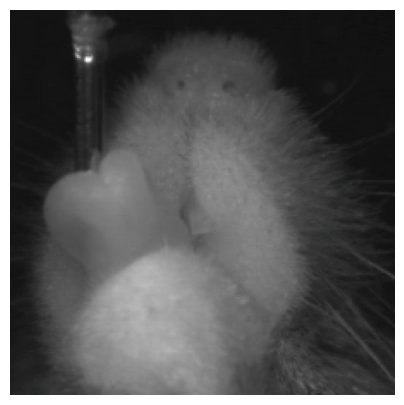

In [18]:
# load an image
img = imgs[np.random.randint(imgs.shape[0])].copy() # select a random image from the array 
img = resize_image(torch.from_numpy(img), (224, 224)).numpy().squeeze()
# convert img to RGB format
img = Image.fromarray(img).convert('RGB') 
img = np.array(img).astype(np.uint8) / 255.

assert img.shape == (224, 224, 3)

# normalize by ImageNet mean and std
img = img - imagenet_mean
img = img / imagenet_std

plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img))

### Load a pre-trained MAE model

In [6]:
# This is an MAE model trained with pixels as targets for visualization (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
!wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large.pth

chkpt_dir = 'mae_visualize_vit_large.pth'
model_mae = prepare_model(chkpt_dir, 'mae_vit_large_patch16')
print('Model loaded.')


File ‘mae_visualize_vit_large.pth’ already there; not retrieving.

<All keys matched successfully>
Model loaded.


### Run MAE on the image

MAE with pixel reconstruction:


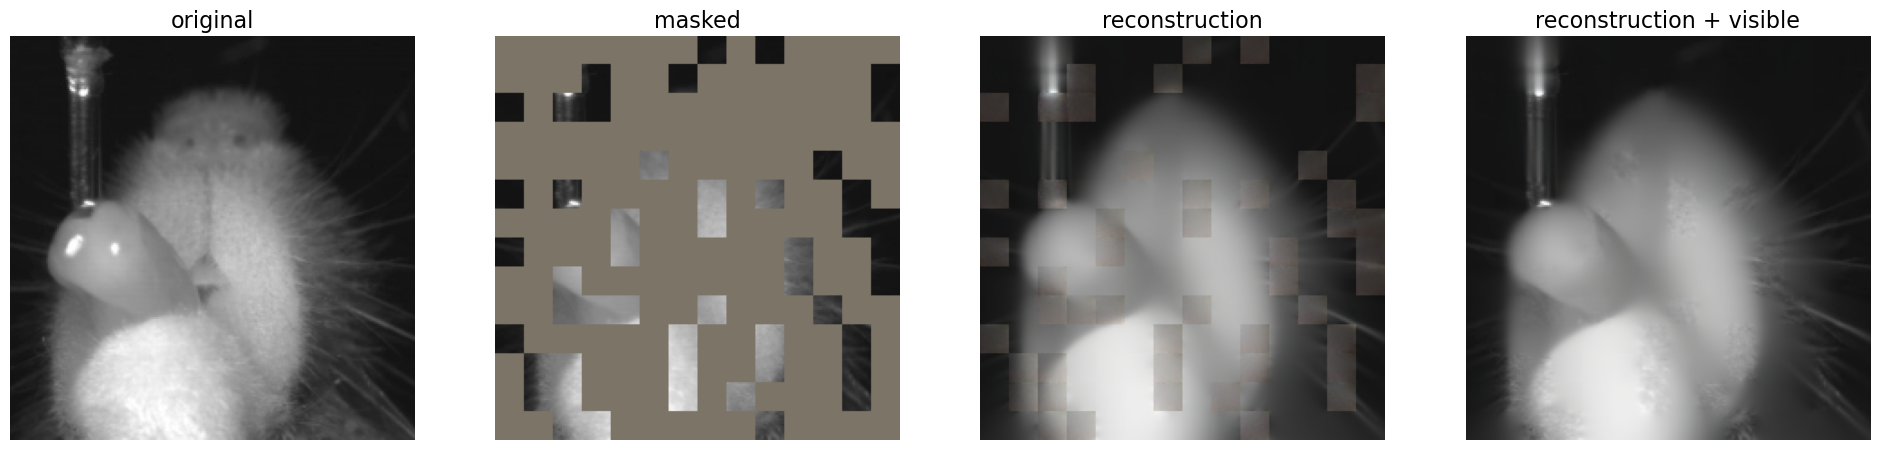

In [7]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with pixel reconstruction:')
run_one_image(img, model_mae)

### Load another pre-trained MAE model

In [38]:
# This is an MAE model trained with an extra GAN loss for more realistic generation (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
!wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large_ganloss.pth

chkpt_dir = 'mae_visualize_vit_large_ganloss.pth' #'/home/stringlab/Desktop/Hopkins_courses/MouseMAE/output_dir/checkpoint-20.pth'#'mae_visualize_vit_large_ganloss.pth'
print("Loading checkpoint from: ", chkpt_dir)
model_mae_gan = prepare_model(chkpt_dir, 'mae_vit_large_patch16')
print('Model loaded.')

File ‘mae_visualize_vit_large_ganloss.pth’ already there; not retrieving.

Loading checkpoint from:  mae_visualize_vit_large_ganloss.pth
<All keys matched successfully>
Model loaded.


### Run MAE on the image

MAE with extra GAN loss:


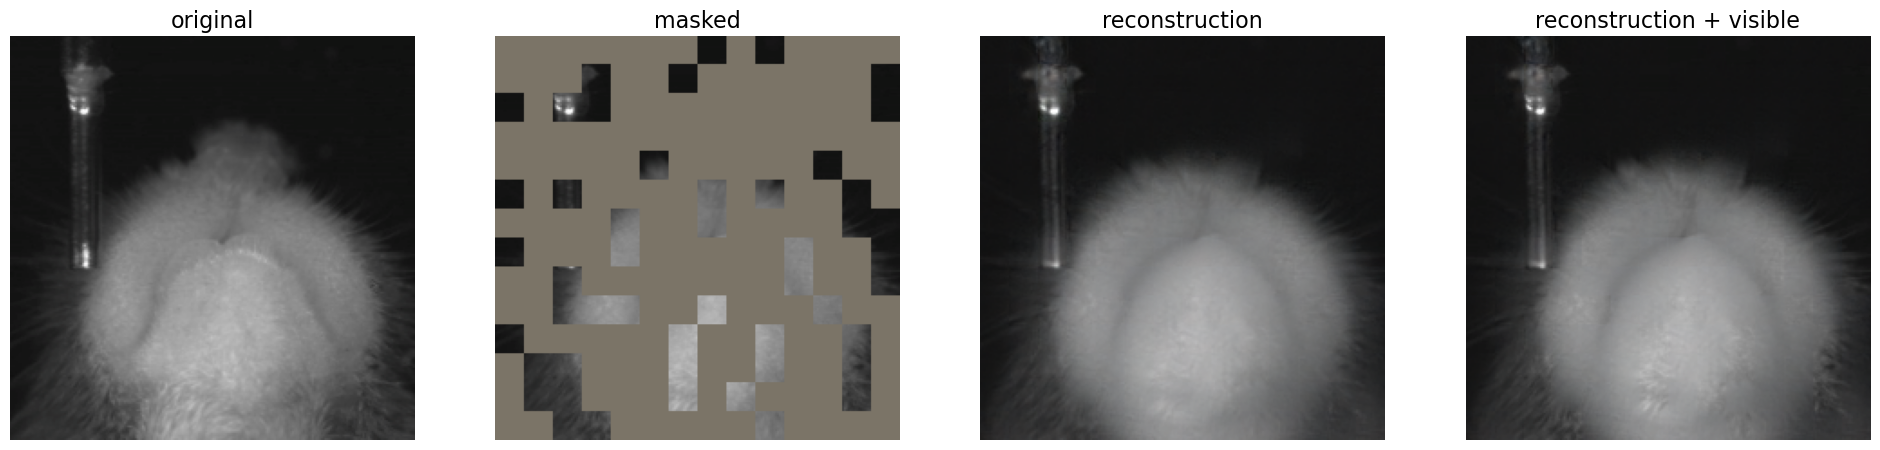

In [39]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with extra GAN loss:')
run_one_image(img, model_mae_gan)

### Run MAE on a video

In [26]:
dataset_files = glob(os.path.join(dat_dir, view, 'test', '*.pkl'))
for dataset_file in dataset_files:
    if 'goldberg' in dataset_file and 'bottom' in view:
        rotate = True   
    else:
        rotate = False
    test_imgs, test_masks, _ = load_data(dataset_file, image_field_name='imgs', mask_field_name='masks', rotate=rotate)

In [44]:
# Run model on each image in the test set
torch.manual_seed(2)
print('MAE with extra GAN loss:')
test_pred = {}
test_pred['original'] = []
test_pred['masked'] = []
test_pred['reconstruction'] = []
test_pred['sum'] = []
for i in tqdm(range(test_imgs.shape[0])):
    img = test_imgs[i].copy()
    img = resize_image(torch.from_numpy(img), (224, 224)).numpy().squeeze()
    # convert img to RGB format
    img = Image.fromarray(img).convert('RGB') 
    img = np.array(img).astype(np.uint8) / 255.
    # normalize by ImageNet mean and std
    img = img - imagenet_mean
    img = img / imagenet_std
    im_masked, y, im_paste = run_one_image(img, model_mae_gan, plot=False)
    test_pred['original'].append(img)
    test_pred['masked'].append(im_masked)
    test_pred['reconstruction'].append(y)
    test_pred['sum'].append(im_paste)

MAE with extra GAN loss:


100%|██████████| 1564/1564 [03:50<00:00,  6.78it/s]


In [45]:
output_filename= 'no_pretraining_ganloss' #'pretraining_ganloss'

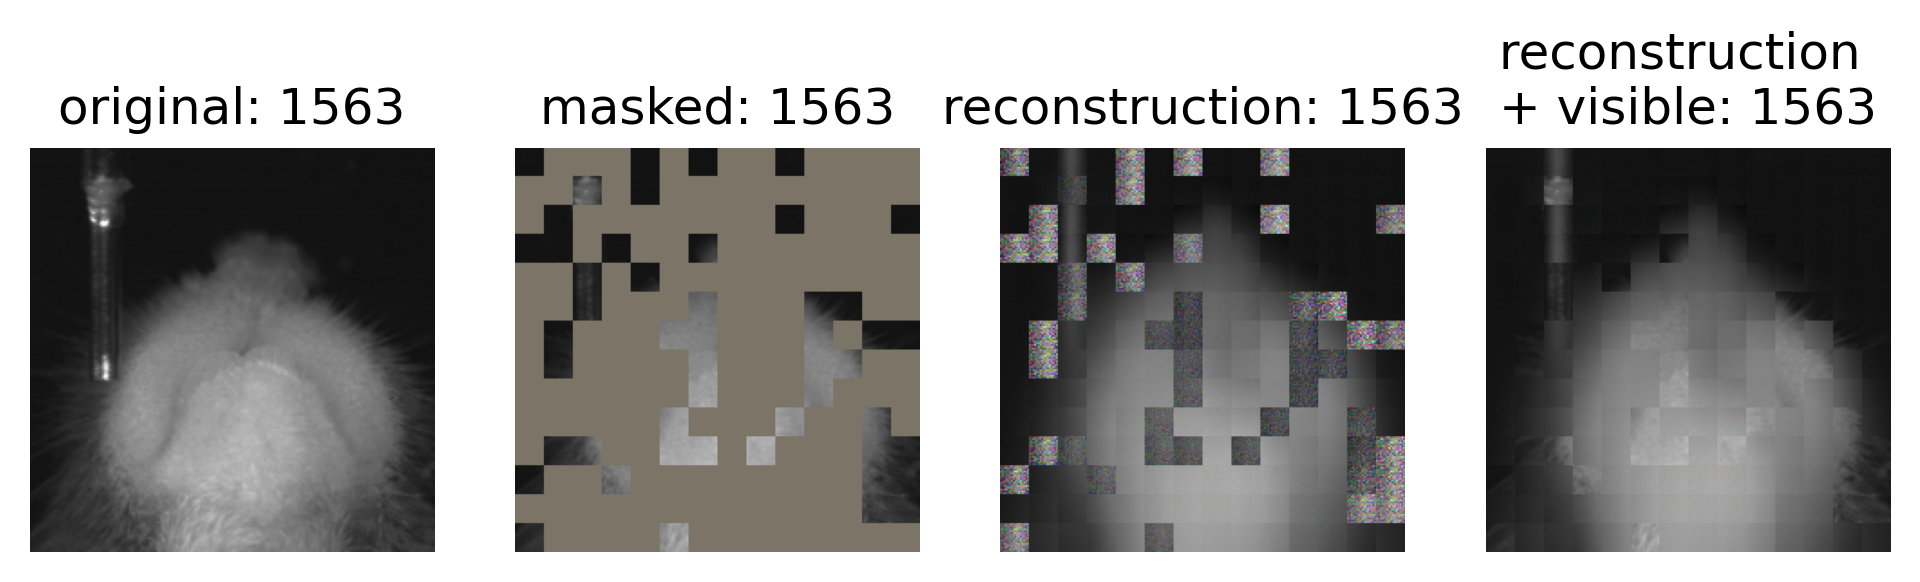

In [29]:
create_animation(test_pred, filename=output_filename)

### Compute accuracy of model on test imgs

In [46]:
# Compute MSE between original and reconstruction for each image
mse = []
for i in range(len(test_pred['original'])):
    mse.append(MSE(test_pred['original'][i], test_pred['sum'][i].numpy()))
print('Mean MSE: ', np.mean(mse))

Mean MSE:  0.07123695800221325


In [47]:
# Save MSE values to file
with open(os.path.join(os.getcwd(), 'results', output_filename+'_mse.txt'), 'w') as f:
    for item in mse:
        f.write("%s\n" % item)
# Save avg MSE to file
with open(os.path.join(os.getcwd(), 'results', output_filename+'_avg_mse.txt'), 'w') as f:
    f.write("%s\n" % np.mean(mse))